In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

In [2]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from stochastic_betting import *

sns.set()
pd.options.display.max_columns = None

# Setup a biased coin
$(p_{coin}, 1-p_{coin})$ denotes the probabilities of the various outcomes.

In [3]:
coin = Coin(p=0.7)

# Random vs Bellman betting

* Random($p$): bet on a direction with probability $p$, the other with probability $p$, the size of the bet at each round is a fixed fraction of the current fortune;
* Bellman($p$): bet on the direction with highest probability, the size of the bet at each round is a fraction $u$ of current fortune $M$ such that
$$
u \in \arg \max_{0\leq u\leq M} \mathbb{E}[\log(M + u\epsilon)],
$$
where $\epsilon$ is a random variable with values +/- 1 depending on whether the bet is successful.

In [4]:
bet_random = RandomBet(coin, init_fortune=100, p=0.7, unit_bet=0.1, bet_style='fractional')
bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.7)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)

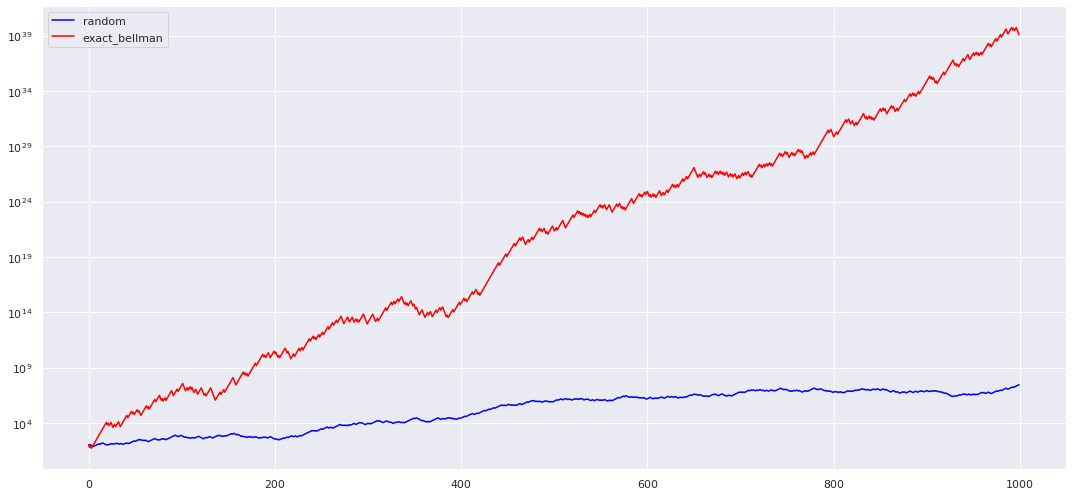

In [5]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

# Empirically check that the Bellman criterion maximizes the log utility of the terminal fortune

In [6]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1])
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1])

print(
    'Expected log fortune:\nRandom: {:.2f}\nExact Bellman: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean())
)


Expected log fortune:
Random: 5.63
Exact Bellman: 12.40


# Random vs Bellman betting with mispecified parameter : right direction but wrong probablity

i.e parameter $p$ in the betting strategy is > $p_{coin} > \frac{1}{2}$.

Bellman still performs well but not optimally (does not maximize the log-utility).

In [7]:
bet_random = RandomBet(coin, init_fortune=100, p=0.8, unit_bet=0.1, bet_style='fractional')
bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.8)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)

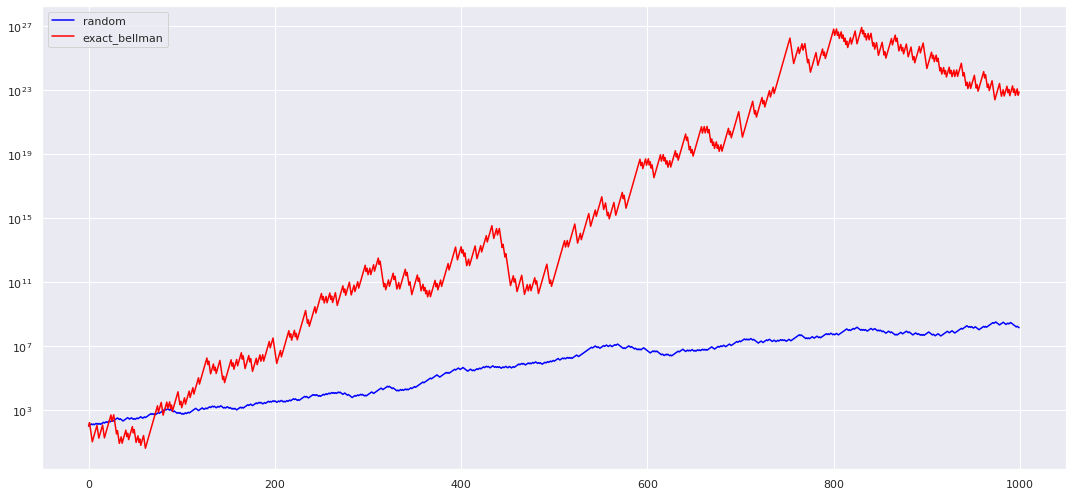

In [8]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [9]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1])
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1])

print(
    'Expected log fortune:\nRandom: {:.2f}\nExact Bellman: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean())
)


Expected log fortune:
Random: 6.53
Exact Bellman: 9.55


# Random vs Bellman betting with mispecified parameter : wrong direction

i.e parameter $p$ in the betting strategy is < $\frac{1}{2}$ while $p_{coin} > \frac{1}{2}$.

Bellman now completely underperforms.

In [10]:
bet_random = RandomBet(coin, init_fortune=100, p=0.49, unit_bet=0.1, bet_style='fractional')
bet_exact_bellman = ExactBellmanBet(coin, init_fortune=100, p=0.49)

N = 1000
results_random = bet_random.simulate(N)
results_exact_bellman = bet_exact_bellman.simulate(N)

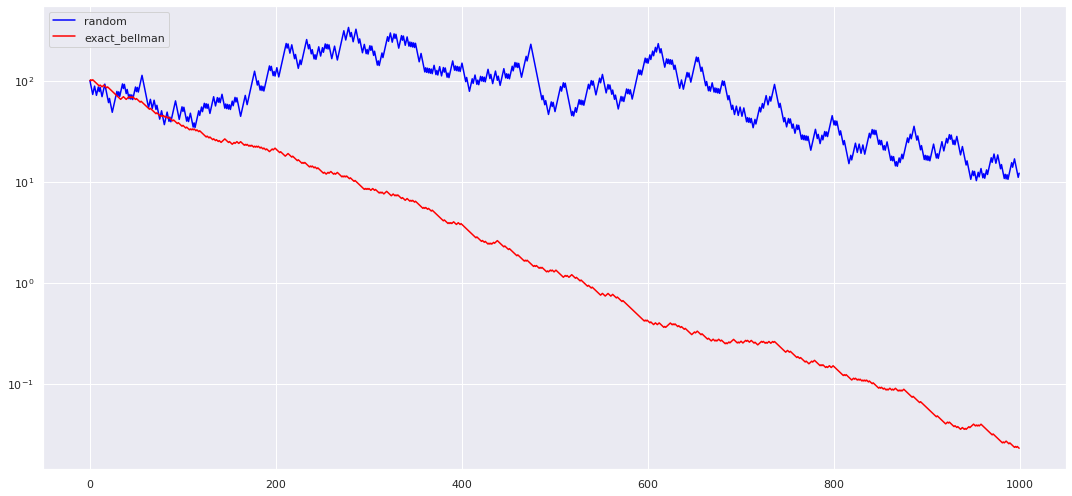

In [11]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(15, 7), nrows=1, ncols=1)
    
    results_random['fortune'].plot(ax=ax, color='blue', label='random', logy=True)
    results_exact_bellman['fortune'].plot(ax=ax, color='red', label='exact_bellman', logy=True)
    
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

In [12]:
n_sim = 100
N = 100

log_fortune_random = np.empty(n_sim)
log_fortune_exact_bellman = np.empty(n_sim)

for i in tqdm(range(n_sim)):
    results_random = bet_random.simulate(N)
    results_exact_bellman = bet_exact_bellman.simulate(N)
    log_fortune_random[i] = np.log(results_random['fortune'].iloc[-1])
    log_fortune_exact_bellman[i] = np.log(results_exact_bellman['fortune'].iloc[-1])

print(
    'Expected log fortune:\nRandom: {:.2f}\nExact Bellman: {:.2f}'.format(
        log_fortune_random.mean(),
        log_fortune_exact_bellman.mean())
)


Expected log fortune:
Random: 4.10
Exact Bellman: 3.81


# TBC : Empirical Bellman, where $p$ is estimated on-the-fly